Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolás Guarín-Zapata 2020. Este material es parte del curso Modelación Computacional en el programa de Ingeniería Civil de la Universidad EAFIT.

# Lectura y procesamiento de mallas de Gmsh

## Introducción

Discutiremos algunos aspectos sobre la creación de mallas de Gmsh,
cómo importarlas y analizar datos asociados a grupos físicos.

**Al completar este notebook usted debería estar en la capacidad de:**

* Entender el concepto de grupo físico en Gmsh.

* Recopilar información asociada a un grupo físico específico.


* Entender el uso de parámetros de mallado en Gmsh.

## Ejemplo: Visualización del esfuerzos para un problema de elasticidad plana

Queremos visualizar el campo de esfuerzos para una placa (infinitamente) grande con un agujero de radio $R$ y sometida a un esfuerzo $p$ remotamente, como se muestra a continuación.

<center>
    <img src="img/cuadrado_hueco.svg"
         alt="Esquema de la geometría."
         style="width:400px">
</center>

Los esfuerzos en este problema están dados por 

\begin{align*}
 \sigma_{rr} &= -\left(1 - \frac{R_1^2}{r^2}\right) p\, ,\\
 \sigma_{\theta\theta} &= -\left(1 + \frac{R_1^2}{r^2} \right) p\, ,\\
 \tau_{r\theta} &= 0\, .
\end{align*}




### Geometría para este problema

Estos son los puntos de nuestro modelo

<center>
    <img src="img/cuadrado_hueco_pts.svg"
         alt="Puntos de la geometría."
         style="width:300px">
</center>

Los puntos 2, 3, 4, y 5 tienen las siguientes coordenadas

$$
x = \pm R \cos\left(\frac{\pi}{4}\right)\, ,\quad
y = \pm R \sin\left(\frac{\pi}{4}\right)\, .
$$

Si conectamos los puntos, obtenemos las siguientes líneas.


<center>
    <img src="img/cuadrado_hueco_lines.svg"
         alt="Líneas de la geometría."
         style="width:300px">
</center>

Los contornos (y superficies) los definimos usando la regla de la mano derecha.

<center>
    <img src="img/cuadrado_hueco_surfs.svg"
         alt="superficies de la geometría."
         style="width:300px">
</center>

Adicionalmente de la información geométrica,
podemos crear grupos (de puntos, líneas, superficies) que
luego podemos usar en nuestras tareas.

<center>
    <img src="img/cuadrado_hueco_groups.svg"
         alt="Grupos físicos de nuestro modelo."
         style="width:400px">
</center>


## Visualización

Inicialmente, veremos cómo visualizar este campo usando únicamente Python. Luego, usaremos Gmsh
para la creación de la geometría y el paquete [meshio](https://github.com/nschloe/meshio) para
importar la malla Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import meshio

La siguiente celda configura algunos aspectos de las gráficas en este Notebook.

In [2]:
%matplotlib notebook
gris = '#757575'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["xtick.color"] = gris
plt.rcParams["ytick.color"] = gris
plt.rcParams["axes.labelcolor"] = gris
plt.rcParams["axes.edgecolor"] = gris
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Definimos una función que me calcule el campo de esfuerzos

In [3]:
def esfuerzos_placa(r, R, p):
    """Campo de esfuerzos para placa con agujero y carga remota
    
    Los parámetros de entrada son:
      r : coordenada del punto.
      R : radio interno de la placa.
      p : valor de la carga remota.
    """
    return -(1 - R**2/r**2)*p,  -(1 + R**2/r**2)*p

## Visualización usando Python únicamente


Si consideramos el dominio de interés como un disco, esta visualización puede ser hecha completamente
en Python.

Inicialmente, definimos las coordenadas de los puntos. Por las características del problema, usaremos
coordenadas polares.

In [4]:
R_in = 1.0
R_out = 10.0

In [5]:
r = np.linspace(R_in, R_out, 20)
theta = np.linspace(0, 2*np.pi, 20)

Ahora, para poder visualizar la solución en 2D necesitamos una rejilla con las coordenadas
$(r, \theta)$. Por suerte, la función ``meshgrid`` de NumPy nos permite crearla.

In [6]:
r, theta = np.meshgrid(r, theta)

Si preferimos trabajar en coordenadas cartesianas podemos usar

\begin{align}
x &= r\cos\theta\\
y &= r\sin\theta
\end{align}

In [7]:
x = r*np.cos(theta)
y = r*np.sin(theta)

Y si hacemos un gráfico de los puntos obtenemos lo siguiente.

<IPython.core.display.Javascript object>


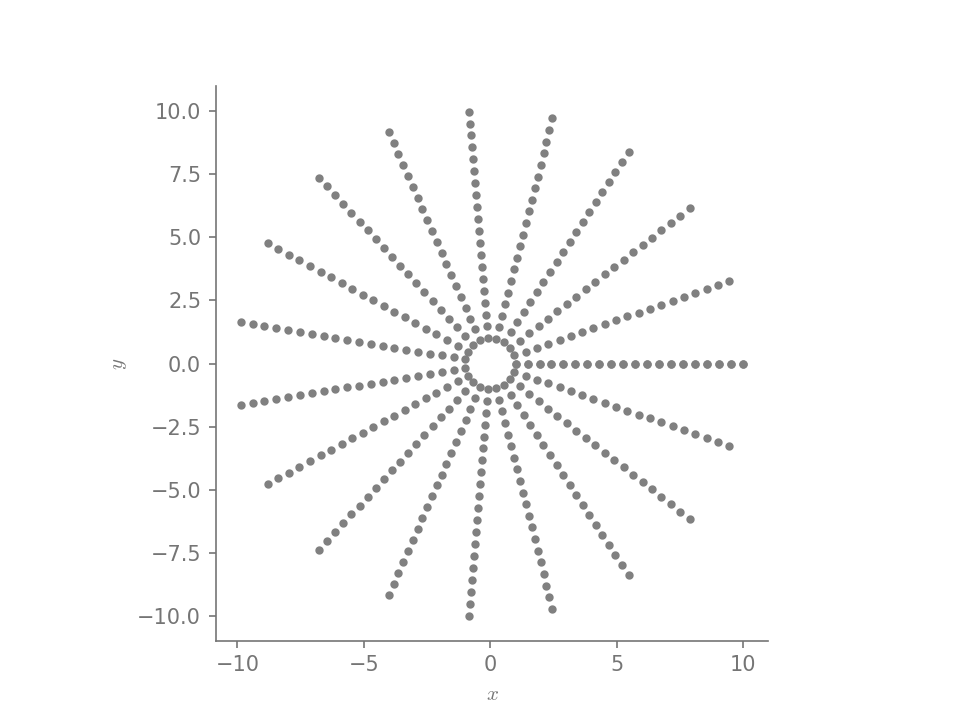

In [8]:
plt.figure()
plt.plot(x, y, ".", color="gray")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("image");

Calculamos los esfuerzos para los puntos

In [9]:
sigma_rr, sigma_tt = esfuerzos_placa(r, R_in, 1.0)

<IPython.core.display.Javascript object>


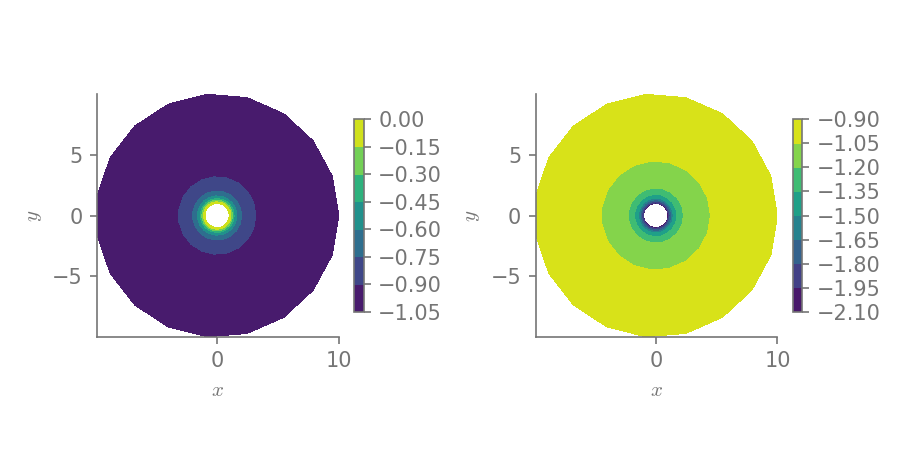

In [10]:
plt.figure(figsize=(6, 3))

# sigma_rr
plt.subplot(1, 2, 1)
plt.contourf(x, y, sigma_rr)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar(shrink=0.5)
plt.axis("image")

#sigma_tt
plt.subplot(1, 2, 2)
plt.contourf(x, y, sigma_tt)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar(shrink=0.5)
plt.axis("image")
plt.tight_layout();

## Visualización creando la geometría en Gmsh

Ahora, si la geometría es más complicada no tendremos una parametrización sencilla
de las coordenadas y no será práctico hacerlo completamente en Python.

En esta sección vamos a leer un archivo de malla creado en Gmsh y luego vamos a
visualizar el mismo campo de esfuerzos.

Podemos leer los archivos de malla generados con Gmsh usando meshio, como se muestra a continuación

In [11]:
mesh = meshio.read("files/cuadrado_hueco.msh")
points = mesh.points
cells = mesh.cells
point_data = mesh.point_data
cell_data = mesh.cell_data

In [12]:
x = points[:, 0]
y = points[:, 1]
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
triangulos = cells["triangle"]

Calculamos los esfuerzos para cada punto en la malla

In [13]:
R = 1.0
p = 1.0
sigma_rr, sigma_tt = esfuerzos_placa(r, R, p)

Y graficamos los esfuerzos

<IPython.core.display.Javascript object>


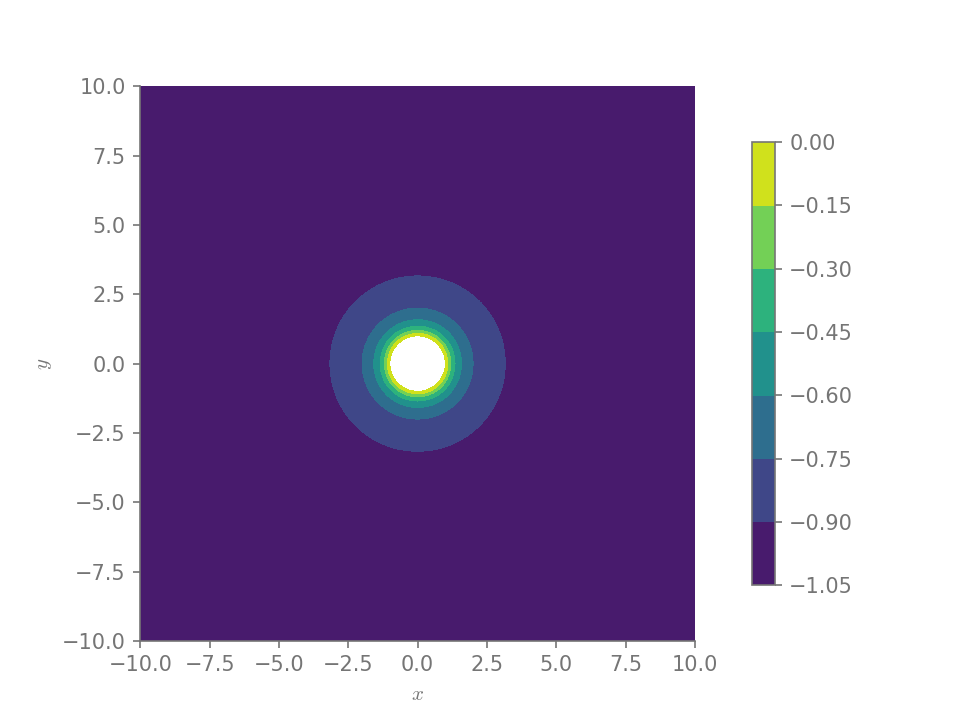

In [14]:
plt.figure()
plt.tricontourf(x, y, triangulos, sigma_rr)
plt.colorbar(shrink=0.8)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("image");

<IPython.core.display.Javascript object>


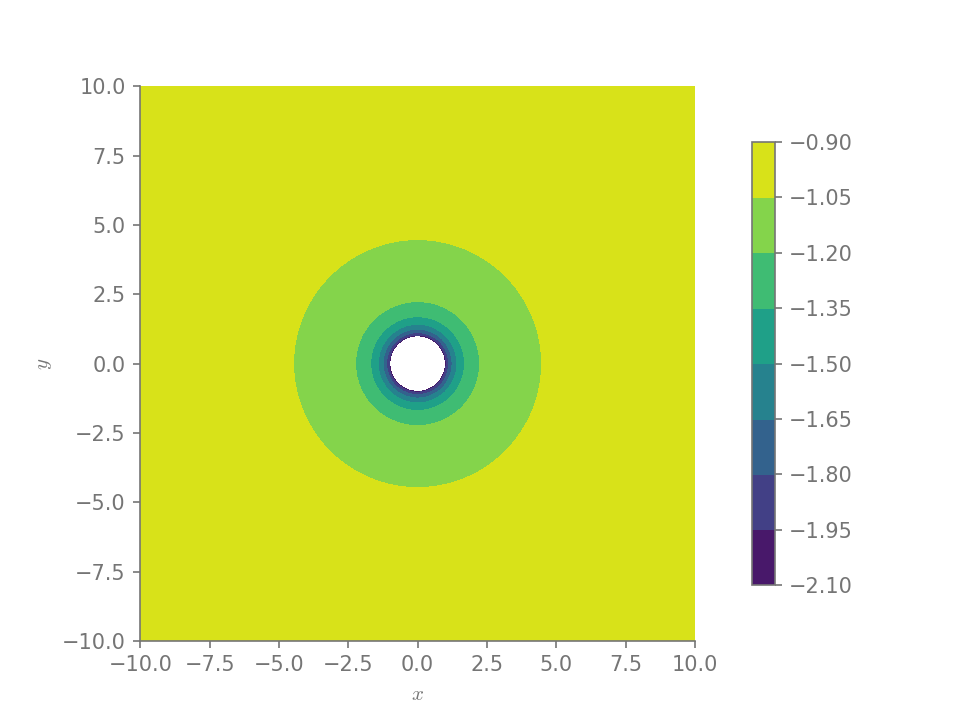

In [15]:
plt.figure()
plt.tricontourf(x, y, triangulos, sigma_tt)
plt.colorbar(shrink=0.8)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("image");

### Visualización de los esfuerzos en la superficie libre y radialmente



In [16]:
grupos_lineas = cell_data["line"]["gmsh:physical"]
lineas = cells["line"]

Para determinar las lineas que corresponden al círculo interior podemos
comparar cuáles líneas tienen el identificador 1. De la siguiente
manera podemos hacerlo

In [17]:
circulo = np.array(lineas[grupos_lineas == 1])
print(circulo)

[[  0 480]
 [480 481]
 [481 482]
 [482 483]
 [483 484]
 [484 485]
 [485 486]
 [486 487]
 [487 488]
 [488 489]
 [489 490]
 [490 491]
 [491 492]
 [492 493]
 [493 494]
 [494 495]
 [495 496]
 [496 497]
 [497 498]
 [498 499]
 [499 500]
 [500 501]
 [501 502]
 [502 503]
 [503 504]
 [504 505]
 [505 506]
 [506 507]
 [507 508]
 [508 509]
 [509 510]
 [510 511]
 [511 512]
 [512 513]
 [513 514]
 [514 515]
 [515 516]
 [516 517]
 [517 518]
 [518   1]
 [  1 519]
 [519 520]
 [520 521]
 [521 522]
 [522 523]
 [523 524]
 [524 525]
 [525 526]
 [526 527]
 [527 528]
 [528 529]
 [529 530]
 [530 531]
 [531 532]
 [532 533]
 [533 534]
 [534 535]
 [535 536]
 [536 537]
 [537 538]
 [538 539]
 [539 540]
 [540 541]
 [541 542]
 [542 543]
 [543 544]
 [544 545]
 [545 546]
 [546 547]
 [547 548]
 [548 549]
 [549 550]
 [550 551]
 [551 552]
 [552 553]
 [553 554]
 [554 555]
 [555 556]
 [556 557]
 [557   2]
 [  2 558]
 [558 559]
 [559 560]
 [560 561]
 [561 562]
 [562 563]
 [563 564]
 [564 565]
 [565 566]
 [566 567]
 [567 568]

Podemos ver que esta lista nos muestra los nodos que forman cada línea en el
círculo interior, sin embargo, algunos puntos aparecen más de una vez.

El siguiente código nos permite tener un arreglo con los nodos sin repeticiones.

In [18]:
circulo = circulo.flatten()
circulo = list(set(circulo))
print(circulo)

[0, 512, 513, 514, 515, 516, 517, 518, 1, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 2, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 3, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511]


In [19]:
theta_circ = theta[circulo]
sigma_rr_circ = sigma_rr[circulo]
sigma_tt_circ = sigma_tt[circulo]

Ahora, necesitamos ordenar estos valores de acuerdo a theta.

In [20]:
orden_theta = np.argsort(theta_circ)

<IPython.core.display.Javascript object>


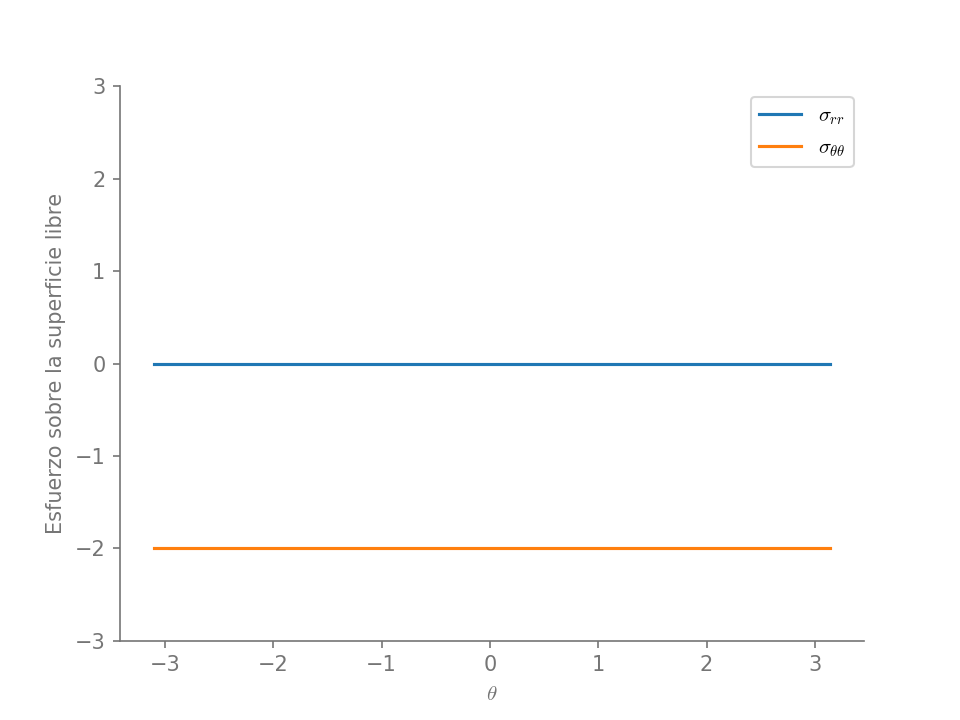

In [21]:
plt.figure()
plt.plot(theta_circ[orden_theta], sigma_rr_circ[orden_theta])
plt.plot(theta_circ[orden_theta], sigma_tt_circ[orden_theta])
plt.xlabel(r"$\theta$")
plt.ylabel("Esfuerzo sobre la superficie libre")
plt.legend([r"$\sigma_{rr}$", r"$\sigma_{\theta\theta}$"])
plt.ylim(-3, 3);

Podemos repetir este proceso para la el grupo asociado al identificador 2.

In [22]:
radio = lineas[grupos_lineas == 2]
radio = radio.flatten()
radio = list(set(radio))
rad = r[radio]
sigma_rr_rad = sigma_rr[radio]
sigma_tt_rad = sigma_tt[radio]
orden_r = np.argsort(rad)

Y podemos ver cómo varía el esfuerzo conforme nos alejamos del origen.

<IPython.core.display.Javascript object>


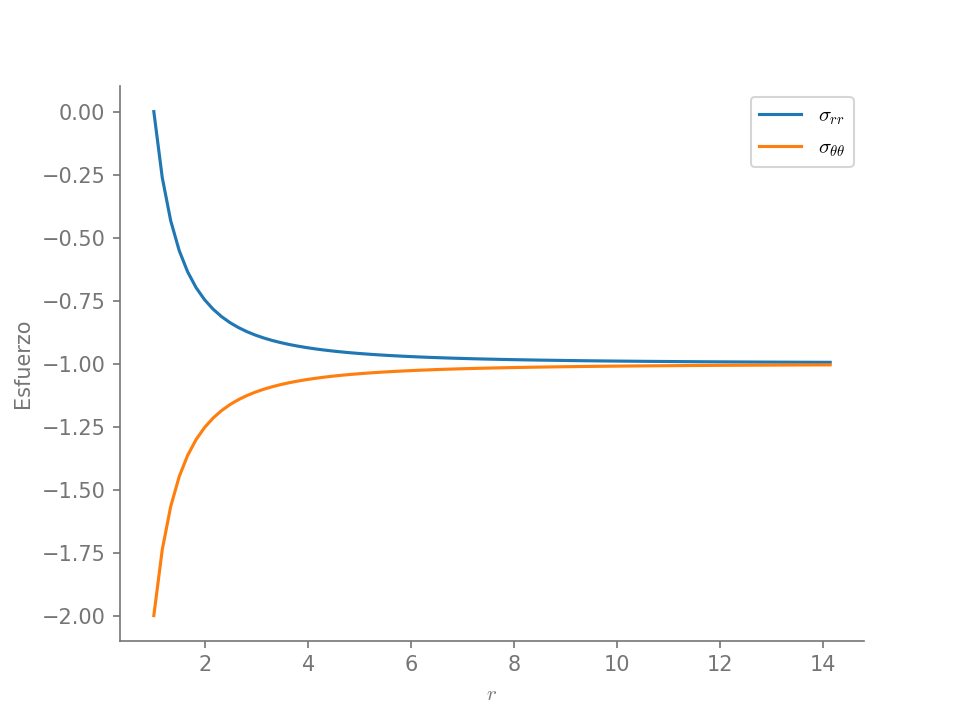

In [23]:
plt.figure()
plt.plot(rad[orden_r], sigma_rr_rad[orden_r])
plt.plot(rad[orden_r], sigma_tt_rad[orden_r])
plt.xlabel(r"$r$")
plt.ylabel("Esfuerzo")
plt.legend([r"$\sigma_{rr}$", r"$\sigma_{\theta\theta}$"]);

## Actividad para la clase

Dada una presa triangular como la que se muestra a continuación

<center>
    <img src="img/presa_tri.svg"
         alt="Esquema de la presa triangular."
         style="width:400px">
</center>

analice los esfuerzos en un notebook nuevo.

La geometría se encuentra en el archivo `presa_triangular.geo` y
la malla en el archivo `presa_triangular.msh`.

## Referencias bibliográficas

1. Gómez, Juan., Sierra, César., Vergara, Juan., Sáenz, Mario., and Guarín-Zapata, Nicolás. (2018) [Notas de clase: Mecánica del medio continuo](https://github.com/AppliedMechanics-EAFIT/Notas-MMC/raw/master/notas_de_clase/notas_medios.pdf). Universidad EAFIT.

## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()